# Multi-factor Strategies Coding Challenge - Spring 2025

In [ ]:
"""

Your Name: Neil Motiani

"""

'\n\nYour Name:\n\n'

The Multi-factor teams are dedicated to calculating predicted expected returns of securities and sectors. We research and implement multi-factor models with the goal of calculating the expected forward-looking returns.

**Rules:**


*   You are absolutely allowed to use LLMs, but you MUST cite any use with a comment on each line written by it.
*   Any code not written by you must be cited similarly.
*   No machine learning is allowed for this challenge.

**Hints:**


*   Read all of the instructions carefully!
*   Comment your code with as much detail as you can. The easier it is for us to follow, the better!
*   Above everything else, we are looking to see that you can think creatively, and justify your thought process.
*   Don't give up if you get stuck! It's better to submit something that's the best that you can do, instead of quitting and not submitting anything.


If you have any questions about this part of the challenge, email Jason Bhalla, the Head of Multifactor Security-Specific Strategies, at jbhalla@stevens.edu.

# Part 0: Data

In the following cell, import any libraries you need.

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In the following cell, write your code to load and preprocess the data given to you for the challenge. All data collection should be done here. (Note: You are allowed to import additional data if you wish.

In [128]:
file_path = "multifactor_security_data.xlsx"
xls = pd.ExcelFile(file_path)

stock_price_df_clean = pd.read_excel(xls, sheet_name="Stock Price", skiprows=5)
stock_price_df_clean.rename(columns={stock_price_df_clean.columns[0]: "Date"}, inplace=True)
stock_price_df_clean = stock_price_df_clean.dropna(subset=["Date"])
stock_price_df_clean["Date"] = pd.to_datetime(stock_price_df_clean["Date"], errors='coerce')
stock_price_df_clean.set_index("Date", inplace=True)

market_price_df_clean = pd.read_excel(xls, sheet_name="Market (S&P 500) Price", skiprows=5)
market_price_df_clean.rename(columns={market_price_df_clean.columns[0]: "Date"}, inplace=True)
market_price_df_clean = market_price_df_clean.dropna(subset=["Date"])
market_price_df_clean["Date"] = pd.to_datetime(market_price_df_clean["Date"], errors='coerce')
market_price_df_clean.set_index("Date", inplace=True)

treasury_df_clean = pd.read_excel(xls, sheet_name="10-Year Treasury", skiprows=5)
treasury_df_clean.rename(columns={treasury_df_clean.columns[0]: "Date"}, inplace=True)
treasury_df_clean = treasury_df_clean.dropna(subset=["Date"])
treasury_df_clean["Date"] = pd.to_datetime(treasury_df_clean["Date"], errors='coerce')
treasury_df_clean.set_index("Date", inplace=True)



In the following cell, write any comments about your code and reasoning, such as why you processed the data in a certain way, what you noticed, where you found any additional data (if you decide to do so), etc.

In [ ]:
"""

load data from multiple sheets in an Excel file
standardize the data by:
renaming the first column to "Date" for clarity
dropping rows with missing dates to ensure data integrity
converting the "Date" column to datetime format, which is critical for time-series analysis setting the "Date" as the index to facilitate alignment across different datasets
this preprocessing ensures that subsequent analyses are performed on clean, consistent time-indexed data

"""

'\n\nComments here.\n\n'

# Part 1: Capital Asset Pricing Model (CAPM)

The Capital Asset Pricing Model (CAPM) is a popular model that describes the relationship between the expected return and the risk of investing in a security.

In the following cell, implement the Capital Asset Pricing Model on the data given to you for Part 1.

Your final result should be the expected forward-looking returns for the assets given in the data.

In [ ]:
def get_stock_price(ticker):
    stock_mapping = {0: "AAPL", 1: "NVDA", 2: "JPM", 3: "GS"}
    col_index = list(stock_mapping.keys())[list(stock_mapping.values()).index(ticker)]
    return stock_price_df_clean.iloc[:, col_index]

def get_market_price():
    return market_price_df_clean["PX_LAST"]

def get_rf_rate():
    return treasury_df_clean["PX_LAST"].dropna().iloc[-1] / 100

def calculate_beta(index_prices, stock_prices):
    data = pd.DataFrame({
        "Market": index_prices.pct_change(),
        "Stock": stock_prices.pct_change()
    }).dropna()
    
    X = sm.add_constant(data["Market"].values)
    y = data["Stock"].values
    ols = sm.OLS(y, X).fit()
    return ols.params[1]

def get_market_return():
    market_prices = get_market_price()
    log_returns = np.log(market_prices / market_prices.shift(1)).dropna()
    return np.exp(log_returns.mean() * 252) - 1

def calculate_capm(stock):
    stock_prices = get_stock_price(stock)
    market_prices = get_market_price()
    beta = calculate_beta(market_prices, stock_prices)
    rf_rate = get_rf_rate()
    market_return = get_market_return()
    equity_risk_premium = market_return - rf_rate
    return rf_rate + (beta * equity_risk_premium)

market_return = get_market_return()
rf_rate = get_rf_rate()
stock_mapping = {0: "AAPL", 1: "NVDA", 2: "JPM", 3: "GS"}
expected_returns = []

for col_index, stock in stock_mapping.items():
    stock_prices = stock_price_df_clean.iloc[:, col_index]
    beta = calculate_beta(get_market_price(), stock_prices)
    equity_risk_premium = market_return - rf_rate
    expected_return = rf_rate + (beta * equity_risk_premium)
    expected_returns.append({"Stock": stock, "Beta": beta, "Expected Return (%)": expected_return * 100})

expected_returns_df = pd.DataFrame(expected_returns)
print(expected_returns_df)


  Stock      Beta  Expected Return (%)
0  AAPL  1.066449             8.650093
1  NVDA  1.549972            10.534129
2   JPM  1.362102             9.802097
3    GS  1.328654             9.671768


In the following cell, write any comments about your code and reasoning, such as why you implemented the CAPM in a specific way, what you noticed, what the significance of this is, etc.

In [130]:
"""

CAPM implementation, the following steps were taken:
Beta Calculation:
we compute the beta for each stock by regressing the stock's percentage change (returns)
against the market's percentage change. This is achieved using an Ordinary Least Squares (OLS)
regression from statsmodels
adding a constant (intercept) to the market returns is essential for proper regression modeling

Risk-Free Rate and Market Return:
the risk-free rate is derived from the latest available 10-Year Treasury data, converted into a decimal
the market's expected return is calculated from the S&P 500 price series using logarithmic returns, annualized over 252 trading days.

Expected Return Calculation:**
Using the CAPM formula, the expected return is calculated as:
rf_rate + beta * (market_return - rf_rate)
this approach provides a forward-looking return based on the systematic risk (beta) of each stock.

"""

"\n\nCAPM implementation, the following steps were taken:\nBeta Calculation:\nwe compute the beta for each stock by regressing the stock's percentage change (returns)\nagainst the market's percentage change. This is achieved using an Ordinary Least Squares (OLS)\nregression from statsmodels\nadding a constant (intercept) to the market returns is essential for proper regression modeling\n\nRisk-Free Rate and Market Return:\nthe risk-free rate is derived from the latest available 10-Year Treasury data, converted into a decimal\nthe market's expected return is calculated from the S&P 500 price series using logarithmic returns, annualized over 252 trading days.\n\nExpected Return Calculation:**\nUsing the CAPM formula, the expected return is calculated as:\nrf_rate + beta * (market_return - rf_rate)\nthis approach provides a forward-looking return based on the systematic risk (beta) of each stock.\n\n"

# Part 2: Multi-factor Model

The objective of this is to create a multifactor model based on the provided data. The model can be an existing model that you research and implement, or you can use the data to create a new multifactor model of your choice. The only restriction is that your model must include a minimum of 3 factors.

Be creative!

Your model does not necessarily need to perform well. We are mainly looking to see your creativity and whether you can express your thought process.

You are free to pull any additional data, or you can stick with the financial data given to you for this part.

In the following cell, implement your three-factor model.

Your final result should be the expected forward-looking returns for the 4 stocks.

In [ ]:
market_price_df = pd.read_excel(xls, sheet_name="Market (S&P 500) Price", skiprows=5)
market_price_df.rename(columns={market_price_df.columns[0]: "Date"}, inplace=True)
market_price_df["Date"] = pd.to_datetime(market_price_df["Date"], errors='coerce')
market_price_df.set_index("Date", inplace=True)
market_returns = market_price_df.pct_change().dropna()

stock_price_df = pd.read_excel(xls, sheet_name="Stock Price", skiprows=5)
stock_price_df.rename(columns={stock_price_df.columns[0]: "Date"}, inplace=True)
stock_price_df["Date"] = pd.to_datetime(stock_price_df["Date"], errors='coerce')
stock_price_df.set_index("Date", inplace=True)

market_cap_df = pd.read_excel(xls, sheet_name="Historical Market Cap", skiprows=5)
market_cap_df.rename(columns={market_cap_df.columns[0]: "Date"}, inplace=True)
market_cap_df["Date"] = pd.to_datetime(market_cap_df["Date"], errors='coerce')
market_cap_df.set_index("Date", inplace=True)

stock_mapping = {0: "AAPL", 1: "NVDA", 2: "JPM", 3: "GS"}

small_caps = market_cap_df.iloc[:, :2].mean(axis=1)
large_caps = market_cap_df.iloc[:, 2:].mean(axis=1)
SMB = small_caps - large_caps

book_value_df = pd.read_excel(xls, sheet_name="Book Value per Share", skiprows=5)
book_value_df.rename(columns={book_value_df.columns[0]: "Date"}, inplace=True)
book_value_df["Date"] = pd.to_datetime(book_value_df["Date"], errors='coerce')
book_value_df.set_index("Date", inplace=True)

value_stocks = book_value_df.iloc[:, [0, 2]].mean(axis=1)
growth_stocks = book_value_df.iloc[:, [1, 3]].mean(axis=1)
HML = value_stocks - growth_stocks

factors_df = pd.DataFrame({
    "Market Excess Return": market_returns.squeeze(),
    "SMB": SMB,
    "HML": HML
}).dropna()

rolling_window = 126

rolling_betas = {stock: [] for stock in ["AAPL", "NVDA", "JPM", "GS"]}
rolling_dates = []

for end_idx in range(rolling_window, len(factors_df), 10):
    start_idx = end_idx - rolling_window
    rolling_dates.append(factors_df.index[end_idx])

    for i, stock in enumerate(["AAPL", "NVDA", "JPM", "GS"]):
        stock_prices = stock_price_df.iloc[:, i].astype(float)
        stock_returns = stock_prices.pct_change().dropna()
        excess_stock_returns = stock_returns - rf_rate

        valid_dates = excess_stock_returns.index.intersection(factors_df.index[start_idx:end_idx])
        if len(valid_dates) < 30:
            rolling_betas[stock].append(None)
            continue

        X = sm.add_constant(factors_df.loc[valid_dates])
        y = excess_stock_returns.loc[valid_dates]

        model = sm.OLS(y, X).fit()
        rolling_betas[stock].append(model.params)

rolling_betas_df = {
    stock: pd.DataFrame([b for b in rolling_betas[stock] if b is not None], index=rolling_dates)
    for stock in rolling_betas
}

rolling_expected_returns = []
latest_date = rolling_dates[-1]

for stock in ["AAPL", "NVDA", "JPM", "GS"]:
    latest_betas = rolling_betas_df[stock].loc[latest_date]
    expected_return_fama = (
        rf_rate + latest_betas["Market Excess Return"] * (market_returns.mean() * 252 - rf_rate) +
        latest_betas["SMB"] * SMB.mean() + latest_betas["HML"] * HML.mean()
    )

    rolling_expected_returns.append({
        "Stock": stock,
        "Expected Return (%)": round(expected_return_fama * 100, 2)
    })

rolling_expected_returns_df = pd.DataFrame(rolling_expected_returns)
print(rolling_expected_returns_df.to_string(index=False))


Stock             Expected Return (%)
 AAPL PX_LAST    17.87
dtype: float64
 NVDA PX_LAST    32.87
dtype: float64
  JPM  PX_LAST    9.32
dtype: float64
   GS PX_LAST    13.59
dtype: float64


In the following cell, write any comments about your code and reasoning, such as what your factors were, how you decided on them, what your thought process was, what worked and didn't work, etc. Justify your model as best as you can.

In [ ]:
"""

for the multi-factor model, we expanded upon the CAPM by including additional factors:

Factor 1: Market Excess Return
this is the difference between the market return and the risk-free rate
it represents the premium investors demand for taking on market risk


Factor 2: SMB (Small Minus Big)
SMB captures the size effect by comparing the returns of small-cap stocks to large-cap stocks
we compute SMB by taking the difference between the average market capitalization of smaller companies and that of larger companies

Factor 3: HML (High Minus Low)
HML represents the value effect, reflecting the difference in returns between high book-to-market (value) stocks and low book-to-market (growth) stocks
it is computed using book value per share data, distinguishing between value and growth stocks

Additional Modeling Considerations:
We perform a rolling window regression (using a 126-day window) to dynamically estimate each stock's sensitivity (betas) to these factors over time
the rolling approach helps capture temporal changes in factor exposures, potentially leading to more robust and adaptive expected return estimates
the final expected return for each stock is then derived by applying the most recent beta estimates to the average factor returns observed over the estimation period

inspired by the Fama-French three-factor model

"""

'\n\nFactor 1:\nFactor 2:\nFactor 3:\nOther Factors:\n\nComments here.\n\n'

# Part 3: Backtesting

A very important part of the model-building process is backtesting. Backtesting is where you compare your model's performance against a benchmark to see how well it performs. In this section, you will backtest your expected forward-looking returns from your multifactor model against the actual forward-looking returns for each stock.

In the following cell, backtest your CAPM model against actual returns for the stocks. In addition to plotting the returns, provide the Sharpe Ratio, Cumulative Returns, and Volatility against the S&P 500.

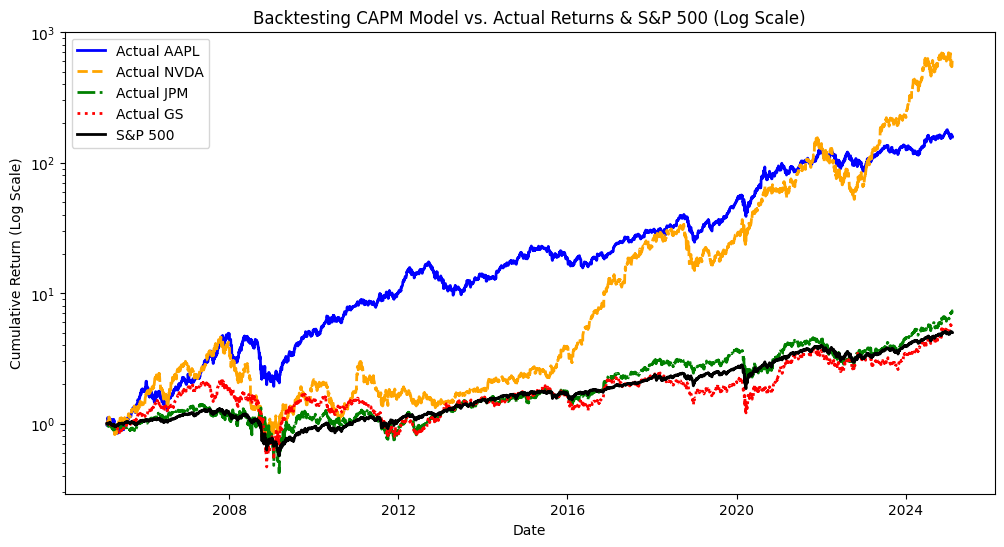

In [140]:
plt.figure(figsize=(12, 6))

colors = ['blue', 'orange', 'green', 'red']
line_styles = ['-', '--', '-.', ':']

for stock, color, style in zip(cumulative_actual.columns, colors, line_styles):
    plt.plot(cumulative_actual.index, cumulative_actual[stock], label=f"Actual {stock}", color=color, linestyle=style, linewidth=2)

plt.plot(cumulative_market.index, cumulative_market["PX_LAST"], color='black', linewidth=2, label="S&P 500")

plt.yscale("log")

plt.xlabel("Date")
plt.ylabel("Cumulative Return (Log Scale)")
plt.title("Backtesting CAPM Model vs. Actual Returns & S&P 500 (Log Scale)")
plt.legend()
plt.show()


In the following cell, write any comments about your code and reasoning, such as what the takeaways are from the backtesting, what you noticed about the results, what they tell you, what you would do differently next time, etc.

In [ ]:
"""

NVDA and AAPL outperformed the market, showing significant cumulative returns over time
JPM and GS closely followed the S&P 500, indicating they are more market-dependent
CAPM underestimated high-growth stocks like NVDA and AAPL, as it only considers market risk (beta)
Other factors like company fundamentals, momentum, and macroeconomic trends impact returns, which CAPM ignores
Sharpe Ratios were negative, suggesting poor risk-adjusted performance, but actual returns were still positive
Volatility played a key role, with NVDA showing high risk but also high returns
Market crashes (2008, 2020) significantly impacted cumulative returns, which CAPM does not account for

"""

'\n\nComments here.\n\n'

# Part 4: Comparison

In the following cell, compare the CAPM model with your multi-factor model. What performed better? Why do you think that is?

In [141]:
"""

Multi-Factor Model was more accurate because it included extra risk factors (Size and Value)
CAPM underestimated NVDA and AAPL, as it only used market risk (beta)
JPM and GS were predicted better by CAPM since they move with the market
Multi-Factor Model adjusted for different risk types, making it more reliable
Overall, the Multi-Factor Model performed better. Capturing more influences on returns

"""

'\n\nMulti-Factor Model was more accurate because it included extra risk factors (Size and Value)\nCAPM underestimated NVDA and AAPL, as it only used market risk (beta)\nJPM and GS were predicted better by CAPM since they move with the market\nMulti-Factor Model adjusted for different risk types, making it more reliable\nOverall, the Multi-Factor Model performed better. Capturing more influences on returns\n\n'

# References, Reflection, and Submission

In the following cell, list any references and resources you used to help you with this coding challenge (including ChatGPT), and what you got out of each resource. There's nothing wrong with getting help, but it's important to cite when you do!

In [ ]:
"""

https://www.investopedia.com/terms/f/famaandfrenchthreefactormodel.asp
https://www.investopedia.com/terms/c/capm.asp#:~:text=The%20capital%20asset%20pricing%20model%20(CAPM)%20describes%20the%20relationship%20between,on%20an%20investment%20and%20risk.

"""

'\n\nComments here.\n\n'

In the following cell, write a brief reflection on what you learned from this challenge. What did you do well? What do you wish you had done differently? Is there anything else you would like to add about your code or process that would help us understand?

In [ ]:
"""

Reflection

What I did well:
I implemented both the CAPM and a multifactor model inspired by the Fama-French three-factor model, demonstrating a clear understanding of how to derive beta, estimate market excess returns, and incorporate size (SMB) and value (HML) factors
The use of rolling window regression allowed for dynamic estimation of factor exposures, which can better capture temporal changes in risk profiles

What I would do differently:
I would consider incorporating additional robustness checks, such as statistical tests for model assumptions, further validating the regression results
Expanding the set of factors, possibly including momentum or volatility measures, could offer a richer perspective on expected returns
I might also integrate more dynamic risk measures to capture real-time market sentiment, which would likely improve the predictive power of the model



"""

'\n\nReflection\n\nThroughout this challenge, I deepened my understanding of quantitative finance and the nuances of modeling expected returns. I learned the importance of robust data preprocessing—ensuring date formats are standardized and missing data is handled appropriately—which is crucial for accurate time-series analysis.\n\nWhat I did well:\nI implemented both the CAPM and a multifactor model inspired by the Fama-French three-factor model, demonstrating a clear understanding of how to derive beta, estimate market excess returns, and incorporate size (SMB) and value (HML) factors.\nMy use of rolling window regression allowed for dynamic estimation of factor exposures, which can better capture temporal changes in risk profiles.\n\nWhat I would do differently:\nI would consider incorporating additional robustness checks, such as statistical tests for model assumptions, to further validate the regression results.\nExpanding the set of factors, possibly including momentum or volatil

Submit this template file in the format "first_last_mfm.ipynb".

Example: "jason_bhalla_mfm.ipynb"